# Project Work: Emotion Detection
## Introduction to Language Technology 2021

Participants:

Hanna Kitti 523087

Kukka Vainio 520261

Topias Salminen 520595

"The contribution of each member of the group should be varied across all the facets of the project, and the project report should include a statement on what the contribution of each member towards each milestone was."

In this notebook we will develop and evaluate a text classification method for identifying emotions expressed in text.

Milestone 1: manual annotation Hanna & Kukka & Topias
- A prerequisite for training a text classifier is to have good quality training data. The data must have input texts (a.k.a documents) and a sentiment or a label (one or multiple) associated with it. In this case we do multiclass classification, i.e we have multiple classes and each document is assigned to one class.
- Data for training this classifier is a joint effort of participants in Turku University course Introduction to Language Technology 2021.

- Some notes we made about the annotation:
  - It was surprisingly hard to detect an emotion in a text. For exampe a text might seem like a neutral statement or a note, even if it contained information about something that is usually considered to be either positive or negative. 
  -  Manual annotation is slow when done by hand by students, but instead of 500 samples each, we could have done at least 1000 and made the dataset a bit bigger.
  - The way to express feelings is not only related to the words used, but also to punctuation and order of the words: "You did what!!??" is generally understood to have different meaning and feeling than "What did you do?" This difference is easy for humans to detect but the data preprocessing in this notebook (Bag of words) looses some of the information when the word context is lost in the preprocessing and also some of the punctuation (although some of these features can be adjusted we will eventually hit some limitations)
  - binary setting of annotation lead to discardin some "joy" and some "anger" when annotating the other

Milestone 2: Hanna & Kukka
- implement machine learning method based on manual annotation created in milestone 1

Milestone 3: Hanna & Kukka & Topias
- evaluate method implemented in milestone 2 
- analyze its errors

In [ ]:
# import libraries here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

# from pprint import pprint
# from time import time
# import logging

## Load and inspect data

In [ ]:
# download data here
%%bash
wget http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/dev.tsv
wget http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/test.tsv
wget http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/train.tsv

pwd # pwd to get to know the current working directory
# rename files with mv, since the data sets have the same names!
mv dev.tsv /content/joy_dev.tsv
mv test.tsv /content/joy_test.tsv
mv train.tsv /content/joy_train.tsv

wget http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/dev.tsv
wget http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/test.tsv
wget http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/train.tsv

mv dev.tsv /content/anger_dev.tsv
mv test.tsv /content/anger_test.tsv
mv train.tsv /content/anger_train.tsv

# files will be in the session folder

/content


--2021-03-26 16:55:26--  http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/dev.tsv
Resolving dl.turkunlp.org (dl.turkunlp.org)... 195.148.30.23
Connecting to dl.turkunlp.org (dl.turkunlp.org)|195.148.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9697 (9.5K) [application/octet-stream]
Saving to: ‘dev.tsv’

     0K .........                                             100% 37.3M=0s

2021-03-26 16:55:27 (37.3 MB/s) - ‘dev.tsv’ saved [9697/9697]

--2021-03-26 16:55:27--  http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/test.tsv
Resolving dl.turkunlp.org (dl.turkunlp.org)... 195.148.30.23
Connecting to dl.turkunlp.org (dl.turkunlp.org)|195.148.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19663 (19K) [application/octet-stream]
Saving to: ‘test.tsv’

     0K .......... .........                                  100%  592K=0.03s

2021-03-26 16:55:27 (592 KB/s) - ‘test.tsv’ saved [19663/19663]

--2021-03-2

In [ ]:
def open_file(file):
  df = pd.read_csv(file, sep='\t', header=None)
  df = df.rename(columns={0: "emotion", 1: "document"})
  return df

joy_dev=open_file("joy_dev.tsv")
joy_test=open_file("joy_test.tsv")
joy_train=open_file("joy_train.tsv")

anger_dev=open_file("anger_dev.tsv")
anger_test=open_file("anger_test.tsv")
anger_train=open_file("anger_train.tsv")

# join the data sets and suffle
dev = pd.concat([joy_dev, anger_dev]).sample(frac=1)
test = pd.concat([joy_test, anger_test]).sample(frac=1)
train = pd.concat([joy_train, anger_train]).sample(frac=1)

print(f"Training data size: {len(train)}, test data size: {len(test)} and development data size: {len(dev)}")
print("And data looks like this:")
dev.head()

Training data size: 2027, test data size: 594 and development data size: 302
And data looks like this:


,emotion,document
125,not-joy,"Äitini oli opettaja, ja isä valvoi hedelmien p..."
139,not-anger,Varmaan vaatii kuitenkin noin vuoden jotta alk...
23,not-joy,Eikö tässä verstaassa levätä?
47,not-anger,Minä kadun. Ja minä.
120,not-joy,En. Meillä oli tärkeämpääkin hoidettavaa.


Let's take a look at how balanced our data is. 

Data quality affects the performance of all machine learning and neural networks. Poor data can not be improved even with a sophisticated algorithm. 

In the otherhand, if we find out that our data is imbalanced, grouped etc. we can fix the issues uprising from the nature of the data before we feed it to the algorithm, or at least take it in account when analysing the results. 

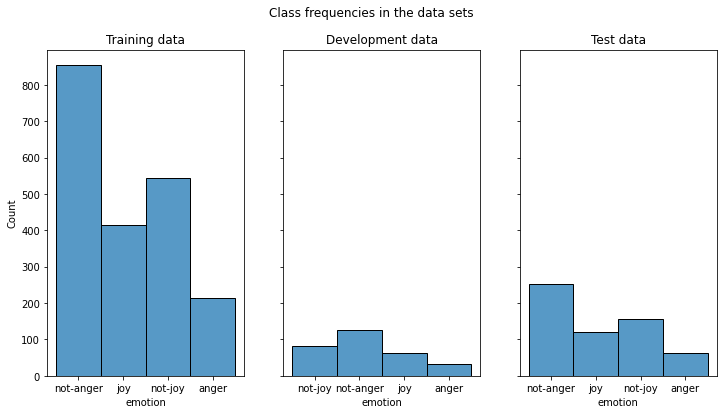

In [ ]:
fig, axes  = plt.subplots(1,3, figsize=(12, 6), sharey=True)
fig.suptitle("Class frequencies in the data sets")

sns.histplot(ax=axes[0], data=train, x = "emotion", discrete=True, )
sns.histplot(ax=axes[1], data=dev, x = "emotion", discrete=True,)
sns.histplot(ax=axes[2], data=test, x = "emotion", discrete=True)

axes[0].set_title("Training data")
axes[1].set_title("Development data")
axes[2].set_title("Test data");

In [ ]:
# inspect the training data class frequencies
df =  train.groupby(["emotion"]).count()
print(df)

           document
emotion            
anger           215
joy             414
not-anger       854
not-joy         544


Training data is all the classifier "sees" during the training and from the features it contains rise all the capabilities of the model. Hence its quality is crucial. For neural networks development data gives feedback and reflects the training process. Test data is always saved intact untill the final model evaluation.

In the training data "joy" and "not-joy" are somewhat equal in terms of class size. However class "not-anger" is approximately 4 times as big as class "anger", which in turn is half of the class sizes of "joy" and "not-joy". 

## Model baseline

Baseline is used to evaluate the model performance alongside with more formal performance measures, to which we will return after the model is trained. 

For a more sophisticated model or a neural network a simpler model may serve as a baseline but here we settle with the simplest possible baseline, which is to assign the most common class in the training data for any new instance. If the model can not outperform this baseline of simply guessing the classification result, it has no further value.

In [ ]:
print(f"Biggest class makes {(854/len(train)*100):0.1f} percentages of the data.")

Biggest class makes 42.1 percentages of the data.


So by just guessing "not-anger" for any new instance we have 42 percent chance of success.

## Prepare data 

Train-dev-test-split is already done, usually splitting the data is part of the preparation. 

For training the model we need to separate labels and documents for all of the data sets.

In [ ]:
train_texts, train_labels = train["document"].tolist(), train["emotion"].tolist()
dev_texts, dev_labels = dev["document"].tolist(), dev["emotion"].tolist()
test_texts, test_labels = test["document"].tolist(), test["emotion"].tolist()

for label, text in zip(train_labels[:5], train_texts[:5]):
  print("label:", label, "\ntext:", text, "\n")

# label-text pairs, now separated:

label: not-anger 
text: Toivottavasti luonasi kaikki kasvaa. 

label: not-anger 
text: Pienistä tahattoman koomisista ylilyönneistä huolimatta Kuu on vaarallinen on viihdyttävä melodraama, koki Harri Moilanen (Kansan Uutiset 10.10.1991). 

label: joy 
text: Ihan totta, mukava nähdä sinua. 

label: joy 
text: Ihanan raikkaan makuista oli ja helppoa ja nopeaa tehdä . 

label: not-anger 
text: Luulisin, että Caravaggio on meidän tämän hetken suosikkimme. 



## Select the algorithm, find hyperparameters and train the model

For the task we have chosen Linear Support Vector Classification. Other possible models for multiclass classification problem are for example K-Nearest-Neighbors and Multinomial Naive Bayes.

When classifying multiple classes and the number of classes in *n* LinearSVC implements “one-vs-the-rest” multi-class strategy, thus training *n* models ([Scikit-learn](https://scikit-learn.org/stable/modules/svm.html#svm-classification)). At prediction time all the classifers "vote", and item will be assigned to class with the lowest cost.

Since we are dealing with text data we need to transform it to format a basic SVM can handle. For that purpose we use sklearn TfidfVectorizer. Also sklearn CountVectorizer was experimented but the results did not differ significantly. We decided to favor TfidfVectorizer since token weigths bear more information than binary present or not values (1/0) or counts of occurence.

Since our group members have different backgrounds we experimented different ways to train the model.

### Finding hyperparameters with for loops

We can train a model and find the suitable hyperparameters by exploring the parameters one by one or with nested for-loops. 

The advantage of looping is that we can rather easily peek into the feature extraction process and keep the code relatively easy to understand. 

new_token_pattern=r"(?u)\b\w\w+\b|!+"

In [ ]:
new_token_pattern=r"(?u)\b\w\w+\b|!+"

vectorizer = TfidfVectorizer(max_features=100000, binary=False, ngram_range=(1,1). token_pattern=new_token_pattern)

feature_matrix_train = vectorizer.fit_transform(train_texts) # note! Fit only the training data
feature_matrix_dev = vectorizer.transform(dev_texts)
feature_matrix_test = vectorizer.transform(test_texts)

print("shape of training data =", feature_matrix_train.shape)
print("shape of development data =", feature_matrix_dev.shape)
print("shape of test data =", feature_matrix_test.shape)

shape of training data = (2027, 8375)
shape of development data = (302, 8375)
shape of test data = (594, 8375)


Let's take a look at the two first items in the training matrix.

In [ ]:
print(feature_matrix_train[:2:].todense()) # row = document, column = term
# mostly zeros here

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
print(feature_matrix_train[:2:]) # (document index and term index) count for the term

  (0, 753)	2
  (0, 4129)	1
  (0, 2286)	1
  (0, 890)	1
  (0, 1569)	1
  (0, 4628)	1
  (0, 7131)	1
  (0, 6655)	1
  (0, 1746)	1
  (0, 2110)	1
  (0, 7034)	1
  (0, 3199)	1
  (0, 5032)	1
  (0, 6209)	1
  (0, 1613)	1
  (0, 5650)	1
  (0, 1805)	1
  (0, 6756)	1
  (0, 1501)	1
  (0, 6106)	1
  (1, 4116)	1
  (1, 733)	1
  (1, 3957)	1
  (1, 4724)	1
  (1, 4992)	1
  (1, 471)	1


In [ ]:
# set the hyperparameter grid
costs = np.logspace(-4, 2, num=6, endpoint = False) # array with values: 0.00001, 0.0001, 0.001, 0.01 0.1, 1

In [ ]:
for cost in costs:
  classifier=LinearSVC(C=cost, verbose=0)
  classifier.fit(feature_matrix_train, train_labels)
  predictions = classifier.predict(feature_matrix_dev)
  acc = accuracy_score(dev_labels, predictions) # same as classifier.score(feature_matrix_dev, dev_label)
  
  print(f"Cost: {cost}")
  print(f"Development accuracy: {acc:0.2f}")
  print()

Cost: 0.0001
Development accuracy: 0.41

Cost: 0.001
Development accuracy: 0.41

Cost: 0.01
Development accuracy: 0.45

Cost: 0.1
Development accuracy: 0.52

Cost: 1.0
Development accuracy: 0.48

Cost: 10.0
Development accuracy: 0.49



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Performance evaluation

Test accuracy: 0.49



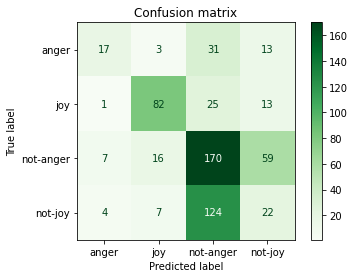

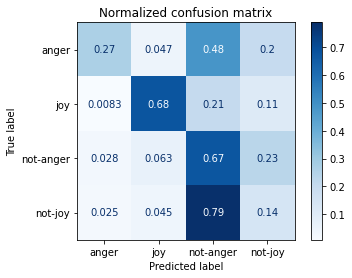

In [ ]:
classifier=LinearSVC(C=0.1, verbose=0)
classifier.fit(feature_matrix_train, train_labels)

predictions = classifier.predict(feature_matrix_test)
train_acc = accuracy_score(train_labels, predictions)
test_acc = accuracy_score(test_labels, predictions)
conf = confusion_matrix(test_labels, predictions)

print(f"Train accuracy: {train_acc:0.2f}") # just to see how "badly" the model learns training data
print(f"Test accuracy: {test_acc:0.2f}")
# print("Confusion matrix:\n", conf)
print()
plot_confusion_matrix(classifier, feature_matrix_test, test_labels, cmap='Greens', values_format='d')  
plt.title("Confusion matrix")
plt.show()

plot_confusion_matrix(classifier, feature_matrix_test, test_labels, cmap='Blues', normalize='true')  
plt.title("Normalized confusion matrix")
plt.show()

Reminder:

Precision: TP/TP+FP --> fraction of true positives of all the items predicted positive. i.e. relevance among the selected items

Recall: TP/TP+FN --> fraction of true positives of all the truly positives. i.e relevant items

- Optimize precision: To achieve high precision we can set high threshold for predicting positive. But this would lead to discarding many positives and thus high FN and bad recall

- Optimize recall: To achieve high recall we must minimize FP. This is achieved by setting a low thrwshold for predicting positive. But this again leads to bad precision!

- Goal: Seek for balance. This migt be achieved by setting the metrics used in training.

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

       anger       0.59      0.27      0.37        64
         joy       0.76      0.68      0.72       121
   not-anger       0.49      0.67      0.56       252
     not-joy       0.21      0.14      0.17       157

    accuracy                           0.49       594
   macro avg       0.51      0.44      0.45       594
weighted avg       0.48      0.49      0.47       594



For joy and not-anger the model finds a bit less than 70 percent of the relevant samples (recall). For joy also precision (relevance of the selected ones) is rather high, close to 80 percent, so the model detects joy the best. This can be seen also from the f1-score. 

Not-anger, the biggest class in our data, has the second highest f1-score and recall close to 70 percent, but since significant amount of not-joy is assigned under not-anger label, the precision for the class is less than 50 percent. Anger seems to be difficult to detect (recall less than 30 percent) but when the model does so, precision is colse to 60 percent. As already mentioned, not-joy is frequently classified to be not-anger, and that is why all the performance measures for this class are poor.

We reach test accuracy around 50 percent. This slightly outperforms our rather naive baseline of guessing the most common class but does not give us results to celebrate with.

Initially we had one data set for "joy" and "not-joy" and other for "anger" and "not-anger". Test accuracy was around 0.84 while testing with anger and joy data separately.

### Finding hyperparameters with GridSearch Cross Validation

When the data set size is limited and we would like to "eat the cake and keep it" we can combine training and development data and use Cross Validation (CV). Dependeing on the algorithm and chosen parameters the data is "folded" (divided into subsets) n times and each of these folds is used once for testing while n-1 folds are used for training.

GridSearchCV allows us set grid (or multiple vectors) of hypermarameters to try with. The idea is to try and find a sweet spot (best performance measure) by adjusting the grid. Here we use GridSearchCV with default 5 folds and stratification, which helps to deal with the imbalanced data when folding. Downside of the GridSearchCV is that computational costs grow fast. In this exercise and with the hyperparameter grid chosen running time remains tolerable. It also itroduces a new hyperparameter, which affects the training results, namely the number of folds.

A simple pipeline is built for both the preprocessor (vectorizer) and the classifier so that we are able to find the best hyperparameters for both of them at once.



Sources:

[GridSearchCV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

[GridSearchCV example 1](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html) 

[GridSearchCV example 2](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html) 

[SVM documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

[GridSearchCV scoring parameters](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) 

In [ ]:
# Combine training and development data
train_texts = train_texts + dev_texts
train_labels = train_labels + dev_labels

print(len(train_labels))

2329


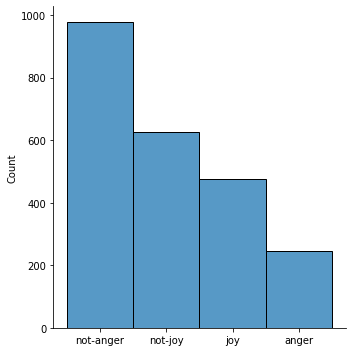

In [ ]:
sns.displot(train_labels, discrete=True);

So we have more data available but the class distributions did not change (seems the original data is stratified).

#### CountVectorizer with SVM

In [ ]:
costs = np.logspace(-4, 2, num=6, endpoint = False) # array with values: 0.00001, 0.0001, 0.001, 0.01 0.1, 1

# token_patternstr, default=r”(?u)\b\w\w+\b”
#  The default regexp select tokens of 2 or more alphanumeric characters 
# (punctuation is completely ignored and always treated as a token separator).
# (?u) unicode flag, see more: https://docs.python.org/2/library/re.html#re.U
# \b Matches empty string
# `\w` same as `[a-zA-Z0-9_]`, matches one alphanumeric character
# + Matches one or more previous RE

new_token_pattern=r"(?u)\b\w\w+\b|!+"

# pipeline = Pipeline([
#     ('vec', TfidfVectorizer()), 
#     ('clf', LinearSVC()),
# ])

pipeline = Pipeline([
    ('vec', CountVectorizer(token_pattern=new_token_pattern)),
    ('clf', LinearSVC()),
])

parameters = {
    'vec__binary': (True, False), # Previous runs revealed this does not seem to matter
    'vec__max_features': (5000, 10000, 30000),
    'vec__ngram_range': ((1, 1), (1, 2), (1, 3)),  
    'clf__C': (costs), 
}

# find the best parameters for both the feature extraction and the classifier
print("Running grid search...")
# scoring: Strategy to evaluate the performance of the cross-validated model on the test set.
gridsearch = GridSearchCV(pipeline, parameters, verbose=1, n_jobs=-1, scoring='f1_weighted') # n_jobs=-1: use as many cores as possible
# f1_weighted for multiclass target
gridsearch.fit(train_texts, train_labels)
print()

print(f"Best score: {gridsearch.best_score_:0.2}")

print("Best of the observed hyperparameters:")
best_parameters = gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
      print(f"{param_name}: {best_parameters[param_name]}")
# print() 
# print("Best model with the given hyperparameters:")
# print(gridsearch.best_estimator_)

Running grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   53.4s



Best score: 0.47
Best of the observed hyperparameters:
clf__C: 0.1
vec__binary: True
vec__max_features: 5000
vec__ngram_range: (1, 1)


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.5min finished


So was the selected model clearly the best?

In [ ]:
# set column visibility in pandas df
pd.set_option("max_colwidth", None)

# extract mean score for each parameter combination trained
means = gridsearch.cv_results_['mean_test_score'] 

GSCV_results = pd.DataFrame(list(zip(means, gridsearch.cv_results_['params'])), 
               columns =['Score', 'Parameters']) 
# sort by the score
GSCV_results.sort_values(by="Score", ascending=False, inplace=True)
print(GSCV_results.head(7))

       Score                                                                                     Parameters
54  0.470030    {'clf__C': 0.1, 'vec__binary': True, 'vec__max_features': 5000, 'vec__ngram_range': (1, 1)}
57  0.467727   {'clf__C': 0.1, 'vec__binary': True, 'vec__max_features': 10000, 'vec__ngram_range': (1, 1)}
60  0.467727   {'clf__C': 0.1, 'vec__binary': True, 'vec__max_features': 30000, 'vec__ngram_range': (1, 1)}
66  0.460525  {'clf__C': 0.1, 'vec__binary': False, 'vec__max_features': 10000, 'vec__ngram_range': (1, 1)}
69  0.460525  {'clf__C': 0.1, 'vec__binary': False, 'vec__max_features': 30000, 'vec__ngram_range': (1, 1)}
87  0.459111  {'clf__C': 1.0, 'vec__binary': False, 'vec__max_features': 30000, 'vec__ngram_range': (1, 1)}
84  0.459111  {'clf__C': 1.0, 'vec__binary': False, 'vec__max_features': 10000, 'vec__ngram_range': (1, 1)}


NOT! The cost seems to be the most important hyperparameter since all the top classifiers share the same cost.

Let's predict the test data anyways.

##### Performance evaluation

Test accuracy: 0.49



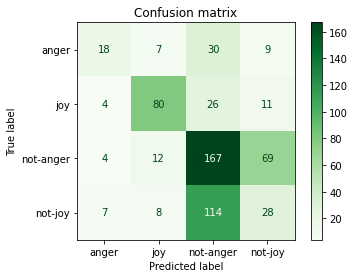

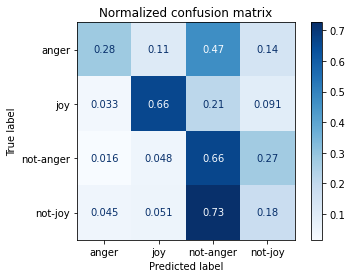

In [ ]:
# classifier=grid_search.best_estimator_
# classifier.fit(feature_matrix_train, train_label)

predictions = gridsearch.predict(test_texts)
acc = accuracy_score(test_labels, predictions)
conf = confusion_matrix(test_labels, predictions)

print(f"Test accuracy: {acc:0.2f}")
# print("Confusion matrix:\n", conf)
print()
# note here we have to feed in the test data not feature matrix since esitimator is a pipeline, not a classifier!
plot_confusion_matrix(gridsearch.best_estimator_, test_texts, test_labels, cmap='Greens', values_format='d')  
plt.title("Confusion matrix")
plt.show()

plot_confusion_matrix(gridsearch.best_estimator_, test_texts, test_labels, cmap='Blues', normalize='true')  
plt.title("Normalized confusion matrix")
plt.show()

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

       anger       0.55      0.28      0.37        64
         joy       0.75      0.66      0.70       121
   not-anger       0.50      0.66      0.57       252
     not-joy       0.24      0.18      0.20       157

    accuracy                           0.49       594
   macro avg       0.51      0.45      0.46       594
weighted avg       0.48      0.49      0.48       594



#### TfidfVectorizer with SVM

In [ ]:
# costs = np.logspace(-4, 2, num=6, endpoint = False) # array with values: 0.00001, 0.0001, 0.001, 0.01 0.1, 1
# adjusted, was array with values: 0.00001, 0.0001, 0.001, 0.01 0.1, 1 AND 1 was best
costs = np.logspace(-1, 2, num=6, endpoint = False)
costs

array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ,
       31.6227766 ])

In [ ]:
new_token_pattern=r"(?u)\b\w\w+\b|!+|\?+"

pipeline = Pipeline([
    ('vec', TfidfVectorizer(token_pattern=new_token_pattern)), 
    ('clf', LinearSVC()),
])

parameters = {
    'vec__binary': (True, False), # Previous runs revealed this does not seem to matter
    'vec__max_features': (5000, 10000, 30000),
    'vec__ngram_range': ((1, 1), (1, 2), (1, 3)),  
    'clf__C': (costs),  
}

print("Running grid search...")
gridsearch = GridSearchCV(pipeline, parameters, verbose=1, n_jobs=-1, scoring='f1_weighted') # n_jobs=-1: use as many cores as possible
gridsearch.fit(train_texts, train_labels)
print()

print(f"Best score: {gridsearch.best_score_:0.2}")

print("Best of the observed hyperparameters:")
best_parameters = gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
      print(f"{param_name}: {best_parameters[param_name]}")
# print() 
# print("Best model with the given hyperparameters:")
# print(gridsearch.best_estimator_)

Running grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   54.8s



Best score: 0.48
Best of the observed hyperparameters:
clf__C: 1.0
vec__binary: True
vec__max_features: 5000
vec__ngram_range: (1, 1)


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.0min finished


In [ ]:
pd.set_option("max_colwidth", None)

means = gridsearch.cv_results_['mean_test_score'] 

GSCV_results = pd.DataFrame(list(zip(means, gridsearch.cv_results_['params'])), 
               columns =['Score', 'Parameters']) 
# sort by the score
GSCV_results.sort_values(by="Score", ascending=False, inplace=True)
print(GSCV_results.head(7))

       Score                                                                                                    Parameters
36  0.483165                   {'clf__C': 1.0, 'vec__binary': True, 'vec__max_features': 5000, 'vec__ngram_range': (1, 1)}
45  0.480771                  {'clf__C': 1.0, 'vec__binary': False, 'vec__max_features': 5000, 'vec__ngram_range': (1, 1)}
18  0.477490   {'clf__C': 0.31622776601683794, 'vec__binary': True, 'vec__max_features': 5000, 'vec__ngram_range': (1, 1)}
27  0.476581  {'clf__C': 0.31622776601683794, 'vec__binary': False, 'vec__max_features': 5000, 'vec__ngram_range': (1, 1)}
39  0.475234                  {'clf__C': 1.0, 'vec__binary': True, 'vec__max_features': 10000, 'vec__ngram_range': (1, 1)}
42  0.475234                  {'clf__C': 1.0, 'vec__binary': True, 'vec__max_features': 30000, 'vec__ngram_range': (1, 1)}
51  0.472653                 {'clf__C': 1.0, 'vec__binary': False, 'vec__max_features': 30000, 'vec__ngram_range': (1, 1)}


##### Performance evaluation

Test accuracy: 0.49



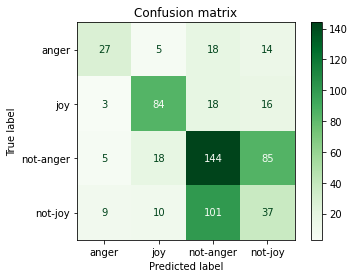

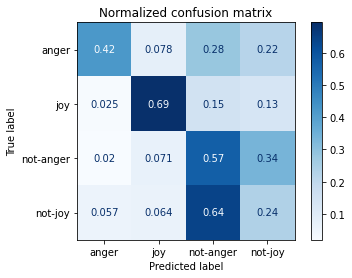

In [ ]:
predictions = gridsearch.predict(test_texts)
acc = accuracy_score(test_labels, predictions)
conf = confusion_matrix(test_labels, predictions)

print(f"Test accuracy: {acc:0.2f}")
# print("Confusion matrix:\n", conf)
print()
# note here we have to feed in the test data not feature matrix since esitimator is a pipeline, not a classifier!
plot_confusion_matrix(gridsearch.best_estimator_, test_texts, test_labels, cmap='Greens', values_format='d')  
plt.title("Confusion matrix")
plt.show()
print()
plot_confusion_matrix(gridsearch.best_estimator_, test_texts, test_labels, cmap='Blues', normalize='true')  
plt.title("Normalized confusion matrix")
plt.show()

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

       anger       0.54      0.41      0.46        64
         joy       0.67      0.71      0.69       121
   not-anger       0.48      0.55      0.52       252
     not-joy       0.23      0.19      0.21       157

    accuracy                           0.47       594
   macro avg       0.48      0.46      0.47       594
weighted avg       0.46      0.47      0.46       594



#### NN


To build a NN we need to

1.   turn numpy vectors to tensors
2.   know the shape of input layer (number of features)
3.   know the shape of output layer (number of classes)

TfidfVectorizer gives the 2nd one and LabelEncoder (for example) the 3rd one. (or just len(set(train_labels))

"Keras models can be used in scikit-learn by wrapping them with the KerasClassifier or KerasRegressor class."(https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)

In [ ]:
# 1) np vectors to TF tensors
import tensorflow as tf
import numpy as np

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

Since vectorizer affects the shape of the NN, we do not optimize it as a part of the pipeline.

In [ ]:
# 2) size of input 
new_token_pattern=r"(?u)\b\w\w+\b|!+|\?+"
vectorizer = TfidfVectorizer(token_pattern=new_token_pattern, max_features=10000)

ft_matrix = vectorizer.fit_transform(train_texts)
ft_matrix.shape # so we need the second dimension for building the nn
input_size = ft_matrix.shape[1]
input_size

9132

In [ ]:
# 3) size_of_output_layer
# use encoded labels when fitting the model and for testing
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder() #Turns class labels into integers
class_numbers_train = label_encoder.fit_transform(train_labels)

# print("class_numbers shape=", class_numbers_train.shape)
print("class labels", label_encoder.classes_) #this will let us translate back from indices to labels

output_size = len(label_encoder.classes_)
print("Shape of output layer:", output_size)

class labels ['anger' 'joy' 'not-anger' 'not-joy']
Shape of output layer: 4


In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout
from keras import optimizers

def build_sequential_nn(input_size=100, output_size=2, hiddenlayer_size=200, drop_out= 0.3, learning_rate=0.001): # let's make 200 default
  model = Sequential()
  model.add(Input(shape = (input_size, )))
  model.add(Dense(hiddenlayer_size, activation = "tanh", ))
  model.add(Dropout(rate=drop_out)) # Dropout regularizer to avoid over fitting
  model.add(Dense(output_size, activation = "softmax"))
  model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=['accuracy'])
  # loss="categorical_crossentropy" for multiclass classification
  return model

model = build_sequential_nn(input_size=input_size, output_size=output_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1826600   
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 1,827,404
Trainable params: 1,827,404
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import FunctionTransformer
from keras.callbacks import EarlyStopping
import time

pipeline = Pipeline([
    ('trans', FunctionTransformer(convert_sparse_matrix_to_sparse_tensor)), # wrapper for custom function
    ('clf', KerasClassifier(build_fn=build_sequential_nn)), # wrapper for Keras model
])

parameters = {
    'clf__hiddenlayer_size': (200, 250), 
    'clf__input_size': ([input_size]), # GS sets ALL the params
    'clf__output_size': ([output_size]),
    'clf__batch_size': (16, 32),
    'clf__drop_out': (0.2, 0.3, 0.4),
    'clf__epochs': (3, 5), # do not use early stopping callback, number of epochs is best treated as a hyper parameter: https://stackoverflow.com/questions/48127550/early-stopping-with-keras-and-sklearn-gridsearchcv-cross-validation
    'clf__learning_rate': (0.001, 0.01)
}

t0=time.time()
print("Running grid search...")
gridsearch = GridSearchCV(pipeline, parameters, verbose=1, n_jobs=1) # n_jobs=-1: use as many cores as possible OR use GPU
gridsearch.fit(ft_matrix, class_numbers_train)
print()

print(f"Best score: {gridsearch.best_score_:0.2}")

print("Best of the observed hyperparameters:")
best_parameters = gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
      print(f"{param_name}: {best_parameters[param_name]}")

t1=time.time()

Running grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Streaming output truncated to the last 5000 lines.
Epoch 8/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0904 - accuracy: 0.9580
Epoch 9/15
117/117 [==============================] - 1s 11ms/step - loss: 0.0914 - accuracy: 0.9516
Epoch 10/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0859 - accuracy: 0.9463
Epoch 11/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0820 - accuracy: 0.9519
Epoch 12/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0696 - accuracy: 0.9622
Epoch 13/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0730 - accuracy: 0.9588
Epoch 14/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0676 - accuracy: 0.9579
Epoch 15/15
30/30 [==============================] - 0s 1ms/step - loss: 1.7463 - accuracy: 0.4635
Epoch 1/15
117/117 [==============================] - 2s 10ms/step - loss: 1.3173 - accuracy: 0.3978
Epoch 2/15
117/117 [=================

In [ ]:
print(f"Time elapsed{t1-t0}")

In [ ]:
means = gridsearch.cv_results_['mean_test_score'] 

GSCV_results = pd.DataFrame(list(zip(means, gridsearch.cv_results_['params'])), 
               columns =['Score', 'Parameters']) 
# sort by the score
GSCV_results.sort_values(by="Score", ascending=False, inplace=True)
print(GSCV_results.head(7))

       Score                                                                                                                                                                  Parameters
26  0.478328  {'clf__batch_size': 32, 'clf__drop_out': 0.2, 'clf__epochs': 3, 'clf__hiddenlayer_size': 250, 'clf__input_size': 9132, 'clf__learning_rate': 0.001, 'clf__output_size': 4}
40  0.476172  {'clf__batch_size': 32, 'clf__drop_out': 0.4, 'clf__epochs': 3, 'clf__hiddenlayer_size': 200, 'clf__input_size': 9132, 'clf__learning_rate': 0.001, 'clf__output_size': 4}
32  0.473606  {'clf__batch_size': 32, 'clf__drop_out': 0.3, 'clf__epochs': 3, 'clf__hiddenlayer_size': 200, 'clf__input_size': 9132, 'clf__learning_rate': 0.001, 'clf__output_size': 4}
34  0.472739  {'clf__batch_size': 32, 'clf__drop_out': 0.3, 'clf__epochs': 3, 'clf__hiddenlayer_size': 250, 'clf__input_size': 9132, 'clf__learning_rate': 0.001, 'clf__output_size': 4}
0   0.472321  {'clf__batch_size': 16, 'clf__drop_out': 0.2, 'clf__epochs': 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test accuracy: 0.50



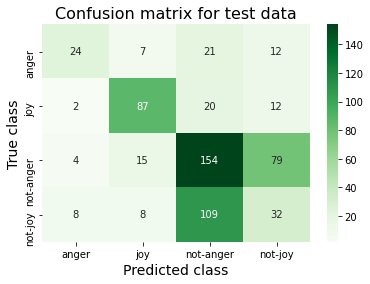

In [ ]:
import seaborn as sns

# prepare test data
ftm_test=vectorizer.transform(test_texts) # model needs to be Sequential for predicting
class_numbers_test = label_encoder.transform(test_labels)

# predict
raw_predictions = gridsearch.predict(ftm_test)
predictions=label_encoder.inverse_transform(raw_predictions)

# results
acc = accuracy_score(test_labels, predictions)
print(f"Test accuracy: {acc:0.2f}")
print()
cf_mat = tf.math.confusion_matrix(
    class_numbers_test, raw_predictions, num_classes=None, weights=None
)

def plot_cf_matrix(mat):
  sns.heatmap(mat, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Greens')
  plt.title("Confusion matrix for test data", fontsize = 16)
  plt.ylabel("True class", fontsize = 14)
  plt.xlabel("Predicted class", fontsize = 14)

plot_cf_matrix(cf_mat)

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

       anger       0.63      0.38      0.47        64
         joy       0.74      0.72      0.73       121
   not-anger       0.51      0.61      0.55       252
     not-joy       0.24      0.20      0.22       157

    accuracy                           0.50       594
   macro avg       0.53      0.48      0.49       594
weighted avg       0.50      0.50      0.49       594



In [ ]:
# From NLP deep learning and ADA courses:

#  Additionally accuracy on the permutated test sets are computed for the purpose of 
# ensuring that performance with actual data differs from performance with junk data.

 # accuracy on permutated test set
    # permutated = np.random.permutation(df_test.reg)
    # perm_accuracy, _ = mnb_compute(vocab['test_fm'], permutated, mnb)

#### Sidenote: How to tackle randomness?

What should be done to make sure our results are not random: resuffle the data, run the CV again. Do this x 10 and take the average.

Run with permuted data

## Model performance evaluation


Let's take a look at the classified test documents. Can we get an insight what went wrong and why?

In [ ]:
df = pd.DataFrame({'true':test_labels,
                   'prediction':list(predictions),
                   'document':test_texts})
print(df.shape)
df.head()

(594, 3)


,true,prediction,document
0,joy,joy,Se on kuulemma tosi hyvä.
1,not-anger,not-anger,Se ei ole niin yksinkertaista.
2,not-joy,not-anger,Se on vika järjestelmässäsi. Alex Murphy on kuollut.
3,not-anger,not-anger,Sikasi pitää hassua ääntä.
4,not-anger,joy,Helpompi hengittely on varmaan mukavampaa ku kaljottelu.


Most of the missclassifications happened when true label was "not-joy" and prediction was falsely "not-anger".

In [ ]:
df1 = df[(df['true']=='not-joy') & (df['prediction']=='not-anger')]
print(df1.shape)
df1.head(20)

(109, 3)


,true,prediction,document
2,not-joy,not-anger,Se on vika järjestelmässäsi. Alex Murphy on kuollut.
7,not-joy,not-anger,"Kuninkaan käskyä noudatettiin , vaikka siitä tehtiinkin useita valituksia ."
10,not-joy,not-anger,"Mitä tehdä, kun lääkäri ei usko puhetta? https://t.co/eJQCOGBDxf"
17,not-joy,not-anger,Muut äidit joutuvat tyytymään siihen mitä luonto antaa.
22,not-joy,not-anger,Dorcas hyvä Rouva Inglethorp on kuollut. Siksi meidän tulee saada tietää kaikki.
27,not-joy,not-anger,"Se hyväksytään jokaisessa tuomioistuimessa - mutta veisin asian jokaiseen tuomioistuimeen, muistakaa se."
30,not-joy,not-anger,Halusin vain lämmittää häntä.
42,not-joy,not-anger,"Jossitteluja sain minäkin palstalla, mutta kukaan ei osunut oikeaan."
45,not-joy,not-anger,Tuulen puoleisen rinteen ilmavirrat tärisyttävät hiukan.
47,not-joy,not-anger,"Voit olla ravintoasiantuntija, vaikka et ole saanut edes yhtä tuntia opetusta yhtään mistään ravintoon liittyvästä."


The next common miss classification was to predict "not-anger" to "not-joy".

In [ ]:
df2 = df[(df['true']=='not-anger') & (df['prediction']=='not-joy')]
print(df2.shape)
df2.head(20)

(79, 3)


,true,prediction,document
6,not-anger,not-joy,Terveydenhuollossa siirryttävä reaktiivisesta kohti proaktiivista ja prediktiivistä toimintatapaa.
18,not-anger,not-joy,Älä kiinnitä huomiota. Anna hänet minulle.
21,not-anger,not-joy,Sun täytyy ruveta terveeksi.
25,not-anger,not-joy,"Jos tiedätte missä hän on, kertokaa minulle, ennen kuin on liian myöhaistä."
28,not-anger,not-joy,Miksi hän kirjoittaa sellaista?
33,not-anger,not-joy,"Hän on hermostunut, tiedäksä?"
36,not-anger,not-joy,"” Houston , meillä on ongelma . ”"
37,not-anger,not-joy,Usko Jumalaan on ihmisen normaali ja terve elämänasenne.
39,not-anger,not-joy,"Ei Liliuksen palkkiot ehkä ole kovin oikeudenmukaisia, mutta ei siihen erityisesti taida olla hyviä keinoja puuttua."
40,not-anger,not-joy,irl ei oikeastaan ratkaise yhtään mitään.


In both of the above cases the documents seem neutral. They truly are not angry neither happy, so classifying these text truly is a tough problem. 

Since data was labeled in two rounds, first detecting joy and marking "not-joy" those documents that did not express joy, and then on the second roud detecting anger and marking the rest "not-anger", in the similar binary fashion, the classes not-joy and not-anger might have formed sort of "garbage classes", containing no emotion or perhaps some emotion but not the one that was looked for. This might lead to situation where the documents in classes "not-joy" and "not-anger" contain no signal for the classifier or some emotion but not joy or anger.

Then again, what do the missclassified "anger" documents look like?

In [ ]:
miss_c_anger = df[(df['true']=='anger') & (df['prediction']!='anger')]
miss_c_anger=miss_c_anger.sort_values(by=['prediction'])
miss_c_anger.shape
miss_c_anger.head(50)

,true,prediction,document
589,anger,joy,Jumala kirotkoon teidät kaikki!
385,anger,joy,@villekoski @juho_koli Vituttaa FB tyyli ilmoitella kaikesta mistä olen sanoen että aion osallistua.
171,anger,joy,Pyyhi tuo ääliömäinen hymy kasvoiltasi!
473,anger,joy,Siis vaahtosi intona sähköiskuja antavasta pannasta!!??
491,anger,joy,Se oli laiton liike!
305,anger,joy,"Pelkästään tuon takia varmistan, että saat kärsiä, puta!"
502,anger,joy,Tässä asiaankuuluva kommentti ; Turhaa!
490,anger,not-anger,Minä teen siitä lopun.
488,anger,not-anger,Enkö käskenyt sinun pysyä kaukana työpöydästäni?
588,anger,not-anger,Suututtaa .


Note here: lots of exclamation marks: these are stripped off from the training data by the vectorizer!

Now what does true and correctly classified anger look like?

In [ ]:
anger = df[(df['true']=='anger') & (df['prediction']=='anger')]
print(anger.shape)
anger.head(50)

(24, 3)


,true,prediction,document
50,anger,anger,Vihaan näitä hinttarimaisia donitsejasi!
64,anger,anger,Vihaan sitä pihiä paskiaista.
97,anger,anger,Mitä vittua ?
99,anger,anger,En halua kuunnella paskaa! - Varo sanojasi.
103,anger,anger,Sanoin sinulle: vältä hankaluuksia.
168,anger,anger,Älä sano noin edes piloillasi.
194,anger,anger,"Helkkari , kaikki epäonnistuu , jos sinä et nyt auta !"
224,anger,anger,Vihaan tätä koko hommaa.
259,anger,anger,Mitä paskaa sä jauhat ?
281,anger,anger,Mitä vittua sinä höpiset?


This does not need any more explanation, lots of coarse language! The problem with anger classification might lie partly in our input data: class anger is the smallest one of them all.

In [ ]:
joy = df[(df['true']=='joy') & (df['prediction']=='joy')]
joy.shape
joy.head(50)

,true,prediction,document
0,joy,joy,Se on kuulemma tosi hyvä.
13,joy,joy,"Ja rakastin hienoa miestä, isääni."
20,joy,joy,"Voi veljet, kuinka iloinen olen nähdessäni sinut!"
34,joy,joy,"Vierailunne on ollut suuri ilo, herra kenraali."
48,joy,joy,Samppanja oli hyvä idea.
55,joy,joy,"Tulkaa, on täällä mukavaa"
58,joy,joy,"Olo oli tosi itsevarma , tuntui että olin saavuttanut jotain elämässäni , ja vielä jotain hyvää oli tulossa ."
61,joy,joy,"lsä, onpa hauskaa nähdä sinut."
73,joy,joy,Se oli elämäni paras päivä .
80,joy,joy,"Tuo on toistaiseksi tärkein todiste, minkä olemme kuulleet."


In [ ]:
# If and when errors were made, what kind of errors?

In [ ]:
# # note here we have to feed in the test data not feature matrix since esitimator is a pipeline, not a classifier!
# plot_confusion_matrix(gridsearch.best_estimator_, test_text, test_label, cmap='Greens', values_format='d')  
# plt.title("Confusion matrix")
# plt.show()

# plot_confusion_matrix(gridsearch.best_estimator_, test_text, test_label, cmap='Blues', normalize='true')  
# plt.title("Normalized confusion matrix")
# plt.show()

In [ ]:
# print(classification_report(test_label, predictions))

## Final notes